# SARIMA From Scratch with MLflow

Monthly sales forecasting using custom SARIMA implementation (no statsmodels).

**Key Features:**
- Log transform with shift constant (no Z-score normalization)
- Explicit double differencing: Seasonal(12) → Regular(1)
- Correct inverse differencing for forecast reconstruction
- Joint AR+MA training with shared residuals
- Baseline comparisons (seasonal naive)
- Complete MLflow state persistence for reproducible inference

## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import os

import mlflow
import mlflow.pyfunc
from mlflow.models.signature import infer_signature

warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = "../dataset/dataset_monthly_cust_l3_sarima.csv"
EXPERIMENT_NAME = "SARIMA_Refactored_v3"
ARTIFACTS_DIR = "./artifacts"

os.makedirs(ARTIFACTS_DIR, exist_ok=True)

mlflow.end_run()
try:
    mlflow.autolog(disable=True)
except:
    pass
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow experiment: {EXPERIMENT_NAME}")

MLflow experiment: SARIMA_Refactored_v3


## 2. Transformation Functions

Log transform with shift constant and double differencing for stationarity.

In [3]:
def compute_log_shift(y):
    min_val = np.min(y)
    if min_val > 0:
        return 0.0
    return 1.0 - min_val


def log_transform(y, shift_constant):
    return np.log(y + shift_constant)


def inverse_log_transform(z, shift_constant):
    return np.exp(z) - shift_constant

In [4]:
def double_difference(z, seasonal_period=12):
    seasonal_diff = z[seasonal_period:] - z[:-seasonal_period]
    w = seasonal_diff[1:] - seasonal_diff[:-1]
    return w, seasonal_diff


def inverse_double_difference(w_forecast, log_history, seasonal_period=12):
    z_extended = list(log_history)
    
    for w in w_forecast:
        z_new = w + z_extended[-1] + z_extended[-seasonal_period] - z_extended[-seasonal_period - 1]
        z_extended.append(z_new)
    
    return np.array(z_extended[len(log_history):])

## 3. ARMA Functions

Autoregression and Moving Average with joint training.

In [5]:
def autoregression(data, p, coefficients):
    total = 0.0
    for i in range(p):
        if i < len(data) and i < len(coefficients):
            total += coefficients[i] * data[-(i + 1)]
    return total


def moving_average(errors, q, coefficients):
    total = 0.0
    for i in range(q):
        if i < len(errors) and i < len(coefficients):
            total += coefficients[i] * errors[-(i + 1)]
    return total

In [6]:
def arma_fit_joint(data, p, q, iterations, learning_rate, l2_reg=0.001):
    n = len(data)
    ar_coeffs = np.zeros(p)
    ma_coeffs = np.zeros(q)
    
    max_lag = max(p, q)
    if max_lag == 0:
        max_lag = 1
    
    errors_history = [0.0] * max_lag
    
    for iteration in range(iterations):
        current_errors = list(errors_history)
        
        for t in range(max_lag, n):
            ar_pred = 0.0
            for i in range(p):
                ar_pred += ar_coeffs[i] * data[t - i - 1]
            
            ma_pred = 0.0
            for i in range(q):
                if len(current_errors) > i:
                    ma_pred += ma_coeffs[i] * current_errors[-(i + 1)]
            
            predict = ar_pred + ma_pred
            error = data[t] - predict
            
            for i in range(p):
                grad = learning_rate * (error * data[t - i - 1] - l2_reg * ar_coeffs[i])
                ar_coeffs[i] += grad
            
            for i in range(q):
                if len(current_errors) > i:
                    grad = learning_rate * (error * current_errors[-(i + 1)] - l2_reg * ma_coeffs[i])
                    ma_coeffs[i] += grad
            
            current_errors.append(error)
            if len(current_errors) > max_lag:
                current_errors.pop(0)
        
        ar_coeffs = np.clip(ar_coeffs, -0.95, 0.95)
        ma_coeffs = np.clip(ma_coeffs, -0.95, 0.95)
        
        errors_history = current_errors[-max_lag:]
    
    return ar_coeffs.tolist(), ma_coeffs.tolist(), errors_history[-q:] if q > 0 else []

## 4. SARIMA Fit and Forecast Functions

In [7]:
def sarima_fit(data, p, d, q, P, D, Q, s, iterations, learning_rate):
    shift_constant = compute_log_shift(data)
    log_data = log_transform(data, shift_constant)
    
    w, seasonal_diff = double_difference(log_data, s)
    
    min_required = max(p, q) + 1
    if len(w) < min_required:
        raise ValueError(f"Not enough data after differencing. Need at least {min_required}, got {len(w)}")
    
    ar_coeffs, ma_coeffs, residual_tail = arma_fit_joint(w, p, q, iterations, learning_rate)
    
    max_lag = max(p, q)
    if max_lag == 0:
        max_lag = 1
    
    in_sample_predictions = []
    current_errors = [0.0] * max_lag
    
    for t in range(max_lag, len(w)):
        ar_pred = autoregression(list(w[:t]), p, ar_coeffs)
        ma_pred = moving_average(current_errors, q, ma_coeffs)
        predict = ar_pred + ma_pred
        in_sample_predictions.append(predict)
        
        error = w[t] - predict
        current_errors.append(error)
        if len(current_errors) > max_lag:
            current_errors.pop(0)
    
    return {
        'shift_constant': shift_constant,
        'ar_coeffs': ar_coeffs,
        'ma_coeffs': ma_coeffs,
        'log_history': list(log_data[-(s + 1):]),
        'diff_tail': list(w[-max(p, 1):]),
        'residual_tail': residual_tail if q > 0 else [0.0],
        'in_sample_predictions': np.array(in_sample_predictions),
        'w': w,
        'log_data': log_data,
        'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q, 's': s
    }

In [8]:
def sarima_forecast(model_state, num_steps):
    p = model_state['p']
    q = model_state['q']
    s = model_state['s']
    ar_coeffs = model_state['ar_coeffs']
    ma_coeffs = model_state['ma_coeffs']
    log_history = model_state['log_history']
    diff_tail = list(model_state['diff_tail'])
    residual_tail = list(model_state['residual_tail'])
    shift_constant = model_state['shift_constant']
    
    w_forecast = []
    
    for step in range(num_steps):
        ar_pred = autoregression(diff_tail, p, ar_coeffs)
        ma_pred = moving_average(residual_tail, q, ma_coeffs)
        w_pred = ar_pred + ma_pred
        
        w_forecast.append(w_pred)
        diff_tail.append(w_pred)
        
        residual_tail.append(0.0)
        if len(residual_tail) > max(q, 1):
            residual_tail.pop(0)
    
    z_forecast = inverse_double_difference(w_forecast, log_history, s)
    y_forecast = inverse_log_transform(z_forecast, shift_constant)
    y_forecast = np.maximum(y_forecast, 0)
    
    return y_forecast

## 5. Baseline Forecast Functions

In [9]:
def seasonal_naive_forecast(train_data, num_steps, seasonal_period=12):
    forecasts = []
    for i in range(num_steps):
        idx = len(train_data) - seasonal_period + (i % seasonal_period)
        if idx < 0:
            idx = len(train_data) - 1
        forecasts.append(train_data[idx])
    return np.array(forecasts)


def last_value_forecast(train_data, num_steps):
    return np.full(num_steps, train_data[-1])

## 6. SARIMA Model Class (MLflow PythonModel)

In [10]:
class SARIMAModel(mlflow.pyfunc.PythonModel):
    def __init__(self, ar_order=1, diff_order=1, ma_order=1, 
                 seasonal_ar_order=0, seasonal_diff_order=1, seasonal_ma_order=0, 
                 seasonal_period=12, iterations=500, learning_rate=0.01):
        self.ar_order = ar_order
        self.diff_order = diff_order
        self.ma_order = ma_order
        self.seasonal_ar_order = seasonal_ar_order
        self.seasonal_diff_order = seasonal_diff_order
        self.seasonal_ma_order = seasonal_ma_order
        self.seasonal_period = seasonal_period
        self.iterations = iterations
        self.learning_rate = learning_rate
        
        self.shift_constant = None
        self.ar_coeffs = None
        self.ma_coeffs = None
        self.log_history = None
        self.diff_tail = None
        self.residual_tail = None
        self.in_sample_predictions = None
        self.w = None
        self.log_data = None
    
    def fit(self, data):
        result = sarima_fit(
            data, self.ar_order, self.diff_order, self.ma_order, 
            self.seasonal_ar_order, self.seasonal_diff_order, self.seasonal_ma_order, 
            self.seasonal_period,
            self.iterations, self.learning_rate
        )
        
        self.shift_constant = result['shift_constant']
        self.ar_coeffs = result['ar_coeffs']
        self.ma_coeffs = result['ma_coeffs']
        self.log_history = result['log_history']
        self.diff_tail = result['diff_tail']
        self.residual_tail = result['residual_tail']
        self.in_sample_predictions = result['in_sample_predictions']
        self.w = result['w']
        self.log_data = result['log_data']
        
        return self
    
    def predict(self, context, model_input):
        if isinstance(model_input, pd.DataFrame):
            num_steps = int(model_input.iloc[0, 0])
        else:
            num_steps = int(model_input)
        
        model_state = {
            'p': self.ar_order,
            'q': self.ma_order,
            's': self.seasonal_period,
            'ar_coeffs': self.ar_coeffs,
            'ma_coeffs': self.ma_coeffs,
            'log_history': self.log_history,
            'diff_tail': self.diff_tail,
            'residual_tail': self.residual_tail,
            'shift_constant': self.shift_constant
        }
        
        return sarima_forecast(model_state, num_steps)
    
    def get_residuals(self):
        if self.w is None or self.in_sample_predictions is None:
            return None
        
        max_lag = max(self.ar_order, self.ma_order)
        if max_lag == 0:
            max_lag = 1
        
        actual = self.w[max_lag:]
        predicted = self.in_sample_predictions
        
        min_len = min(len(actual), len(predicted))
        return actual[:min_len] - predicted[:min_len]
    
    def get_model_state(self):
        return {
            'p': self.ar_order, 'd': self.diff_order, 'q': self.ma_order,
            'P': self.seasonal_ar_order, 'D': self.seasonal_diff_order, 'Q': self.seasonal_ma_order,
            's': self.seasonal_period,
            'iterations': self.iterations, 'learning_rate': self.learning_rate,
            'shift_constant': self.shift_constant,
            'ar_coeffs': self.ar_coeffs, 'ma_coeffs': self.ma_coeffs,
            'log_history': self.log_history, 'diff_tail': self.diff_tail, 'residual_tail': self.residual_tail
        }

c:\Users\cogli\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


## 7. Metrics and Plotting Functions

In [11]:
def calculate_metrics(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    n = len(actual)
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    
    mask = actual != 0
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    else:
        mape = np.nan
    
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'N': n}


def compute_acf(residuals, max_lag=12):
    n = len(residuals)
    mean = np.mean(residuals)
    var = np.var(residuals)
    
    if var == 0:
        return np.zeros(max_lag + 1)
    
    acf = []
    for k in range(max_lag + 1):
        if k == 0:
            acf.append(1.0)
        else:
            cov = np.sum((residuals[:-k] - mean) * (residuals[k:] - mean)) / n
            acf.append(cov / var)
    
    return np.array(acf)

In [12]:
def plot_residuals(residuals, segment, target, save_path):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(residuals, 'b-', linewidth=0.8)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
    axes[0].set_title(f'Residuals in Double-Differenced Log Space - {segment} {target}')
    axes[0].set_xlabel('Time Index')
    axes[0].set_ylabel('Residual')
    axes[0].grid(True, alpha=0.3)
    
    acf = compute_acf(residuals, max_lag=12)
    lags = np.arange(len(acf))
    
    axes[1].bar(lags, acf, color='steelblue', edgecolor='black')
    n = len(residuals)
    conf_interval = 1.96 / np.sqrt(n)
    axes[1].axhline(y=conf_interval, color='r', linestyle='--', alpha=0.7, label='95% CI')
    axes[1].axhline(y=-conf_interval, color='r', linestyle='--', alpha=0.7)
    axes[1].axhline(y=0, color='black', linewidth=0.5)
    axes[1].set_title('Residual ACF')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Autocorrelation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    return save_path


def plot_test_vs_forecast(test_dates, test_actual, sarima_forecast_vals, baseline_forecast, 
                          segment, target, save_path):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(test_dates, test_actual, 'b-o', linewidth=2, markersize=6, label='Actual')
    ax.plot(test_dates, sarima_forecast_vals, 'r--s', linewidth=2, markersize=6, label='SARIMA Forecast')
    ax.plot(test_dates, baseline_forecast, 'g:^', linewidth=2, markersize=6, label='Seasonal Naive')
    
    ax.set_title(f'Test vs Forecast - {segment} {target}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Units')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    return save_path

## 8. Load and Prepare Data

In [13]:
monthly_df = pd.read_csv(DATA_PATH)
monthly_df['date'] = pd.to_datetime(monthly_df['ACCOUNTING_PERIOD'], format='%Y%m')
monthly_df = monthly_df.sort_values(['CUST_STEERING_L3_NAME', 'date'])

segments = monthly_df['CUST_STEERING_L3_NAME'].unique().tolist()
print(f"Segments: {segments}")
print(f"Date range: {monthly_df['date'].min()} to {monthly_df['date'].max()}")
monthly_df.head()

Segments: ['DEALER', 'OEM', 'PROFESSIONAL END-USERS']
Date range: 2023-01-01 00:00:00 to 2025-10-01 00:00:00


,CUST_STEERING_L3_NAME,ACCOUNTING_PERIOD,net_sales_units,returns_units,total_net_units,date
0,DEALER,202301,8755.0,3626.0,5129.0,2023-01-01
1,DEALER,202302,11174.0,4278.0,6896.0,2023-02-01
2,DEALER,202303,13309.0,5245.0,8064.0,2023-03-01
3,DEALER,202304,10029.0,3870.0,6159.0,2023-04-01
4,DEALER,202305,11125.0,4765.0,6360.0,2023-05-01


## 9. Train/Test Split Configuration

In [14]:
train_end_date = pd.Timestamp('2025-08-01')
test_end_date = pd.Timestamp('2025-10-01')

print(f"Training period: Start - {train_end_date}")
print(f"Test period: {train_end_date} - {test_end_date}")


def split_data(df, segment, target_col, train_end, test_end):
    segment_df = df[df['CUST_STEERING_L3_NAME'] == segment].copy()
    segment_df = segment_df.sort_values('date')
    
    train_df = segment_df[segment_df['date'] <= train_end]
    test_df = segment_df[(segment_df['date'] > train_end) & (segment_df['date'] <= test_end)]
    
    train_data = train_df[target_col].values
    test_data = test_df[target_col].values
    train_dates = train_df['date'].values
    test_dates = test_df['date'].values
    
    return train_data, test_data, train_dates, test_dates

Training period: Start - 2025-08-01 00:00:00
Test period: 2025-08-01 00:00:00 - 2025-10-01 00:00:00


## 10. Training Function with MLflow Logging

In [15]:
def train_and_log_model(segment, target_col, target_label, 
                        p, d, q, P, D, Q, s,
                        iterations, learning_rate):
    train_data, test_data, train_dates, test_dates = split_data(
        monthly_df, segment, target_col, train_end_date, test_end_date
    )
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{segment}_{target_label}_p{p}d{d}q{q}_P{P}D{D}Q{Q}s{s}_{timestamp}"
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("segment", segment)
        mlflow.log_param("target", target_label)
        mlflow.log_param("p", p)
        mlflow.log_param("d", d)
        mlflow.log_param("q", q)
        mlflow.log_param("seasonal_P", P)
        mlflow.log_param("seasonal_D", D)
        mlflow.log_param("seasonal_Q", Q)
        mlflow.log_param("s", s)
        mlflow.log_param("iterations", iterations)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("train_size", len(train_data))
        mlflow.log_param("test_size", len(test_data))
        
        model = SARIMAModel(
            ar_order=p, diff_order=d, ma_order=q,
            seasonal_ar_order=P, seasonal_diff_order=D, seasonal_ma_order=Q,
            seasonal_period=s,
            iterations=iterations,
            learning_rate=learning_rate
        )
        model.fit(train_data)
        
        mlflow.log_param("shift_constant", model.shift_constant)
        mlflow.log_param("ar_coeffs", str(model.ar_coeffs))
        mlflow.log_param("ma_coeffs", str(model.ma_coeffs))
        
        if len(test_data) > 0:
            test_predictions = model.predict(None, len(test_data))
            sarima_metrics = calculate_metrics(test_data, test_predictions)
            
            baseline_preds = seasonal_naive_forecast(train_data, len(test_data), s)
            baseline_metrics = calculate_metrics(test_data, baseline_preds)
        else:
            test_predictions = np.array([])
            sarima_metrics = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'R2': np.nan}
            baseline_preds = np.array([])
            baseline_metrics = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan, 'R2': np.nan}
        
        for metric_name, metric_value in sarima_metrics.items():
            if metric_name != 'N' and not np.isnan(metric_value):
                mlflow.log_metric(f"sarima_{metric_name}", metric_value)
        
        for metric_name, metric_value in baseline_metrics.items():
            if metric_name != 'N' and not np.isnan(metric_value):
                mlflow.log_metric(f"baseline_seasonal_{metric_name}", metric_value)
        
        if sarima_metrics['RMSE'] < baseline_metrics['RMSE']:
            mlflow.log_metric("beats_baseline", 1)
        else:
            mlflow.log_metric("beats_baseline", 0)
        
        residuals = model.get_residuals()
        if residuals is not None and len(residuals) > 0:
            residuals_path = os.path.join(ARTIFACTS_DIR, f"residuals_{segment}_{target_label}.png")
            plot_residuals(residuals, segment, target_label, residuals_path)
            mlflow.log_artifact(residuals_path)
        
        if len(test_data) > 0:
            test_dates_pd = pd.to_datetime(test_dates)
            forecast_path = os.path.join(ARTIFACTS_DIR, f"forecast_{segment}_{target_label}.png")
            plot_test_vs_forecast(
                test_dates_pd, test_data, test_predictions, baseline_preds,
                segment, target_label, forecast_path
            )
            mlflow.log_artifact(forecast_path)
        
        example = pd.DataFrame({'forecast_periods': [12]})
        signature = infer_signature(example, np.array([0.0] * 12))
        
        mlflow.pyfunc.log_model(
            name="sarima_model",
            python_model=model,
            input_example=example,
            signature=signature
        )
        
        run_id = mlflow.active_run().info.run_id
    
    return {
        'model': model,
        'sarima_metrics': sarima_metrics,
        'baseline_metrics': baseline_metrics,
        'test_predictions': test_predictions,
        'baseline_predictions': baseline_preds,
        'test_data': test_data,
        'test_dates': test_dates,
        'train_data': train_data,
        'train_dates': train_dates,
        'run_id': run_id
    }

## 11. Model Configuration and Training

In [16]:
SARIMA_P = 0
SARIMA_D = 1
SARIMA_Q = 1
SARIMA_CAP_P = 1
SARIMA_CAP_D = 1
SARIMA_CAP_Q = 0
SARIMA_S = 12

ITERATIONS = 1000
LEARNING_RATE = 0.01

targets = {
    'net_sales_units': 'net_sales',
    'returns_units': 'returns'
}

print(f"SARIMA Order: ({SARIMA_P},{SARIMA_D},{SARIMA_Q})({SARIMA_CAP_P},{SARIMA_CAP_D},{SARIMA_CAP_Q})[{SARIMA_S}]")
print(f"Iterations: {ITERATIONS}, Learning Rate: {LEARNING_RATE}")

SARIMA Order: (0,1,1)(1,1,0)[12]
Iterations: 1000, Learning Rate: 0.01


In [17]:
all_results = {}
all_metrics = []

for segment in segments:
    print(f"\n{'='*60}")
    print(f"Training: {segment}")
    print('='*60)
    
    all_results[segment] = {}
    
    for target_col, target_label in targets.items():
        print(f"\n  Target: {target_label}")
        
        result = train_and_log_model(
            segment, target_col, target_label,
            SARIMA_P, SARIMA_D, SARIMA_Q, 
            SARIMA_CAP_P, SARIMA_CAP_D, SARIMA_CAP_Q, SARIMA_S,
            ITERATIONS, LEARNING_RATE
        )
        
        all_results[segment][target_label] = result
        
        sarima_m = result['sarima_metrics']
        baseline_m = result['baseline_metrics']
        
        all_metrics.append({
            'Segment': segment,
            'Target': target_label,
            'Order': f"({SARIMA_P},{SARIMA_D},{SARIMA_Q})({SARIMA_CAP_P},{SARIMA_CAP_D},{SARIMA_CAP_Q})[{SARIMA_S}]",
            'SARIMA_RMSE': sarima_m['RMSE'],
            'SARIMA_MAPE': sarima_m['MAPE'],
            'SARIMA_R2': sarima_m['R2'],
            'Baseline_RMSE': baseline_m['RMSE'],
            'Baseline_MAPE': baseline_m['MAPE'],
            'Beats_Baseline': sarima_m['RMSE'] < baseline_m['RMSE']
        })
        
        print(f"    SARIMA  -> RMSE: {sarima_m['RMSE']:.2f}, MAPE: {sarima_m['MAPE']:.2f}%")
        print(f"    Baseline -> RMSE: {baseline_m['RMSE']:.2f}, MAPE: {baseline_m['MAPE']:.2f}%")
        print(f"    Beats Baseline: {sarima_m['RMSE'] < baseline_m['RMSE']}")

print("\n" + "="*60)
print("Training complete!")
print("="*60)


Training: DEALER

  Target: net_sales


2025/12/11 23:21:56 INFO mlflow.pyfunc: Validating input example against model signature


    SARIMA  -> RMSE: 3907.86, MAPE: 55.34%
    Baseline -> RMSE: 3685.09, MAPE: 53.59%
    Beats Baseline: False

  Target: returns


2025/12/11 23:22:03 INFO mlflow.pyfunc: Validating input example against model signature


    SARIMA  -> RMSE: 2520.48, MAPE: 510.35%
    Baseline -> RMSE: 2699.63, MAPE: 548.73%
    Beats Baseline: True

Training: OEM

  Target: net_sales


2025/12/11 23:22:07 INFO mlflow.pyfunc: Validating input example against model signature


    SARIMA  -> RMSE: 329.51, MAPE: 37.85%
    Baseline -> RMSE: 143.26, MAPE: 15.48%
    Beats Baseline: False

  Target: returns


2025/12/11 23:22:12 INFO mlflow.pyfunc: Validating input example against model signature


    SARIMA  -> RMSE: 111.90, MAPE: 0.56%
    Baseline -> RMSE: 104.72, MAPE: 7.63%
    Beats Baseline: False

Training: PROFESSIONAL END-USERS

  Target: net_sales


2025/12/11 23:22:16 INFO mlflow.pyfunc: Validating input example against model signature


    SARIMA  -> RMSE: 438.15, MAPE: 15.47%
    Baseline -> RMSE: 449.39, MAPE: 15.22%
    Beats Baseline: True

  Target: returns


2025/12/11 23:22:20 INFO mlflow.pyfunc: Validating input example against model signature


    SARIMA  -> RMSE: 94.88, MAPE: 22.58%
    Baseline -> RMSE: 101.77, MAPE: 19.75%
    Beats Baseline: True

Training complete!


## 12. Accuracy Metrics Summary

In [18]:
metrics_df = pd.DataFrame(all_metrics)
print("\n" + "="*80)
print("SARIMA MODEL ACCURACY METRICS (Test Set)")
print("="*80)
display(metrics_df)

metrics_df.to_csv(os.path.join(ARTIFACTS_DIR, 'accuracy_metrics.csv'), index=False)


SARIMA MODEL ACCURACY METRICS (Test Set)


,Segment,Target,Order,SARIMA_RMSE,SARIMA_MAPE,SARIMA_R2,Baseline_RMSE,Baseline_MAPE,Beats_Baseline
0,DEALER,net_sales,"(0,1,1)(1,1,0)[12]",3907.864787,55.335830,-2.494449,3685.093011,53.586836,False
1,DEALER,returns,"(0,1,1)(1,1,0)[12]",2520.482425,510.345275,-0.588208,2699.629049,548.727468,True
2,OEM,net_sales,"(0,1,1)(1,1,0)[12]",329.514523,37.850075,-1.370946,143.263743,15.483914,False
3,OEM,returns,"(0,1,1)(1,1,0)[12]",111.896295,0.564266,0.100777,104.721058,7.627119,False
4,PROFESSIONAL END-USERS,net_sales,"(0,1,1)(1,1,0)[12]",438.151770,15.466143,0.062412,449.391811,15.223414,True
5,PROFESSIONAL END-USERS,returns,"(0,1,1)(1,1,0)[12]",94.881862,22.581161,0.159601,101.769347,19.752321,True


## 13. Generate Future Forecasts

In [19]:
forecast_horizon = 12
last_date = monthly_df['date'].max()
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')

print(f"Last closed month: {last_date}")
print(f"Forecast period: {forecast_dates[0]} to {forecast_dates[-1]}")

future_forecasts = {}

for segment in segments:
    segment_df = monthly_df[monthly_df['CUST_STEERING_L3_NAME'] == segment].sort_values('date')
    full_net_sales = segment_df['net_sales_units'].values
    full_returns = segment_df['returns_units'].values
    
    model_ns = SARIMAModel(
        ar_order=SARIMA_P, diff_order=SARIMA_D, ma_order=SARIMA_Q,
        seasonal_ar_order=SARIMA_CAP_P, seasonal_diff_order=SARIMA_CAP_D, seasonal_ma_order=SARIMA_CAP_Q,
        seasonal_period=SARIMA_S,
        iterations=ITERATIONS, learning_rate=LEARNING_RATE
    )
    model_ns.fit(full_net_sales)
    forecast_ns = model_ns.predict(None, forecast_horizon)
    
    model_ret = SARIMAModel(
        ar_order=SARIMA_P, diff_order=SARIMA_D, ma_order=SARIMA_Q,
        seasonal_ar_order=SARIMA_CAP_P, seasonal_diff_order=SARIMA_CAP_D, seasonal_ma_order=SARIMA_CAP_Q,
        seasonal_period=SARIMA_S,
        iterations=ITERATIONS, learning_rate=LEARNING_RATE
    )
    model_ret.fit(full_returns)
    forecast_ret = model_ret.predict(None, forecast_horizon)
    
    forecast_total = np.maximum(forecast_ns - forecast_ret, 0)
    
    future_forecasts[segment] = {
        'dates': forecast_dates,
        'net_sales': forecast_ns,
        'returns': forecast_ret,
        'total_net': forecast_total,
        'historical_dates': segment_df['date'].values,
        'historical_total': segment_df['total_net_units'].values
    }
    
    print(f"\n{segment} Forecast:")
    for i in range(forecast_horizon):
        print(f"  {forecast_dates[i].strftime('%Y-%m')}: Net={forecast_ns[i]:.0f}, Returns={forecast_ret[i]:.0f}, Total={forecast_total[i]:.0f}")

Last closed month: 2025-10-01 00:00:00
Forecast period: 2025-11-01 00:00:00 to 2026-10-01 00:00:00

DEALER Forecast:
  2025-11: Net=7955, Returns=537, Total=7418
  2025-12: Net=5082, Returns=329, Total=4753
  2026-01: Net=5278, Returns=276, Total=5002
  2026-02: Net=5826, Returns=309, Total=5517
  2026-03: Net=5435, Returns=313, Total=5123
  2026-04: Net=4538, Returns=282, Total=4256
  2026-05: Net=6062, Returns=321, Total=5741
  2026-06: Net=6576, Returns=393, Total=6183
  2026-07: Net=5617, Returns=304, Total=5313
  2026-08: Net=5198, Returns=336, Total=4862
  2026-09: Net=5730, Returns=390, Total=5340
  2026-10: Net=3150, Returns=31, Total=3118

OEM Forecast:
  2025-11: Net=833, Returns=0, Total=833
  2025-12: Net=952, Returns=1, Total=951
  2026-01: Net=911, Returns=0, Total=910
  2026-02: Net=590, Returns=0, Total=590
  2026-03: Net=545, Returns=0, Total=545
  2026-04: Net=838, Returns=1, Total=836
  2026-05: Net=926, Returns=1, Total=925
  2026-06: Net=1102, Returns=2, Total=1100

## 14. Forecast Visualization

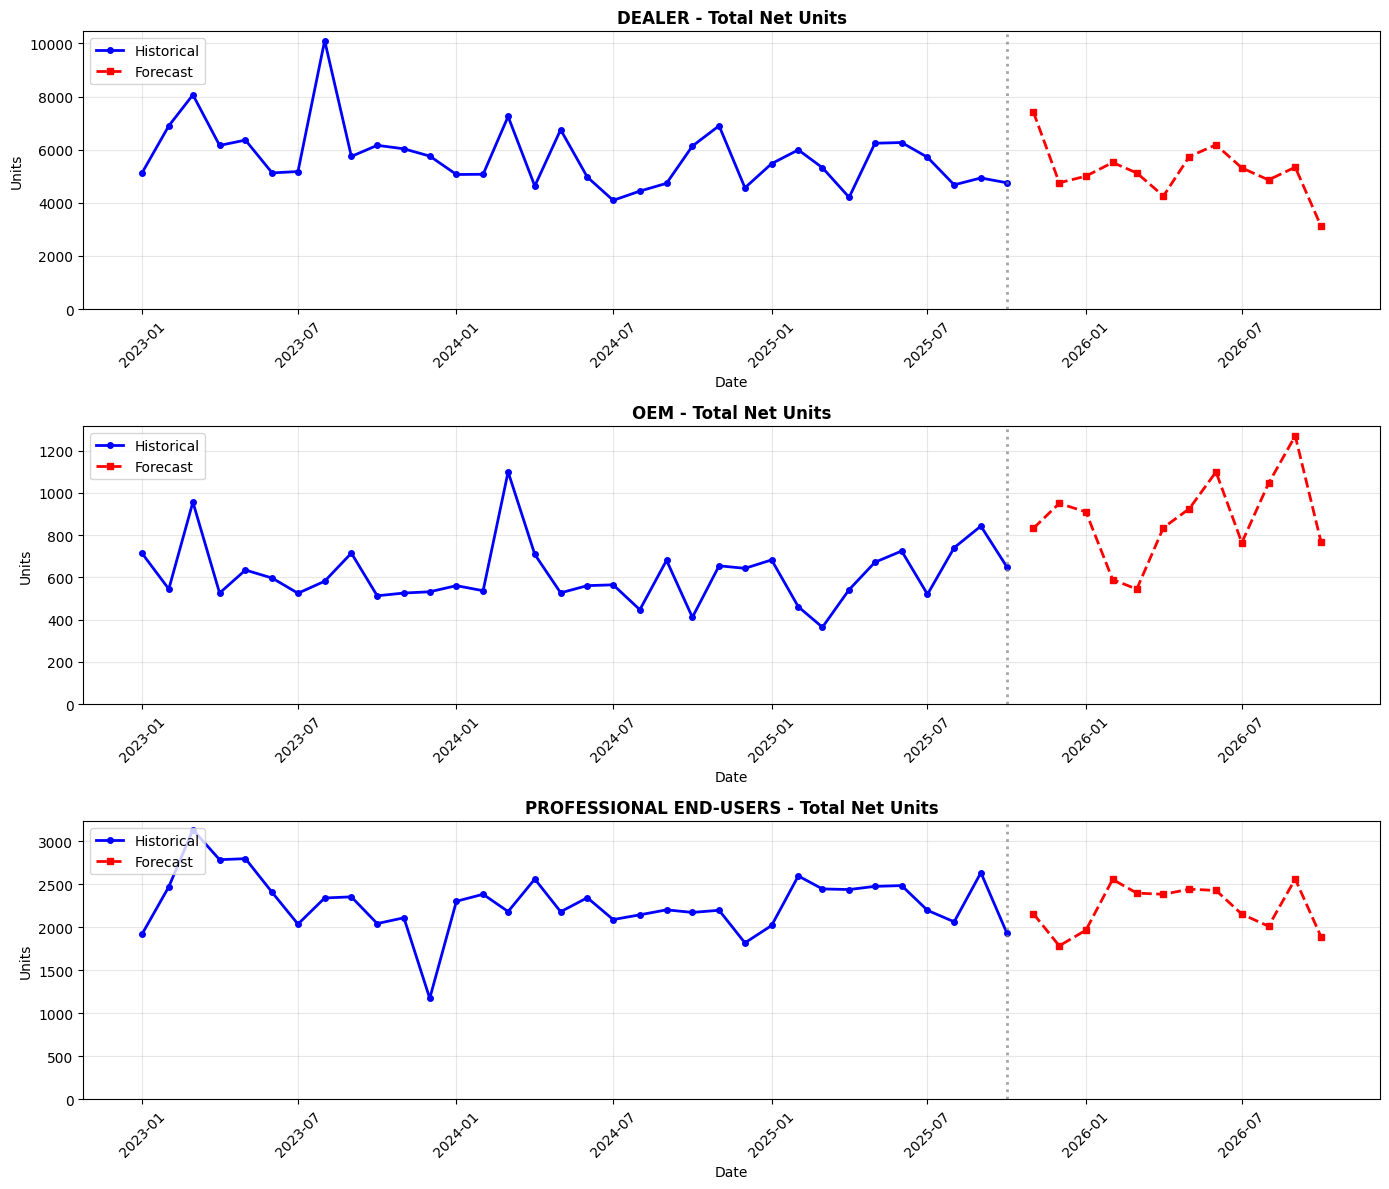


Forecast visualization saved.


In [20]:
fig, axes = plt.subplots(len(segments), 1, figsize=(14, 4 * len(segments)))

if len(segments) == 1:
    axes = [axes]

for idx, segment in enumerate(segments):
    ax = axes[idx]
    data = future_forecasts[segment]
    
    hist_dates = pd.to_datetime(data['historical_dates'])
    hist_values = data['historical_total']
    
    ax.plot(hist_dates, hist_values, 'b-', linewidth=2, label='Historical', marker='o', markersize=4)
    
    fore_dates = data['dates']
    fore_values = data['total_net']
    
    ax.plot(fore_dates, fore_values, 'r--', linewidth=2, label='Forecast', marker='s', markersize=4)
    
    ax.axvline(x=hist_dates.max(), color='gray', linestyle=':', alpha=0.7, linewidth=2)
    
    ax.set_title(f'{segment} - Total Net Units', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Units')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'sarima_forecast_visualization.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nForecast visualization saved.")

## 15. Export Results

In [21]:
all_forecasts = []

for segment in segments:
    data = future_forecasts[segment]
    for i, date in enumerate(data['dates']):
        all_forecasts.append({
            'segment': segment,
            'forecast_date': date,
            'net_sales_forecast': data['net_sales'][i],
            'returns_forecast': data['returns'][i],
            'total_net_forecast': data['total_net'][i]
        })

forecasts_df = pd.DataFrame(all_forecasts)
forecasts_df.to_csv('../dataset/sarima_forecasts.csv', index=False)
print("Forecasts exported to: ../dataset/sarima_forecasts.csv")

display(forecasts_df.head(15))

Forecasts exported to: ../dataset/sarima_forecasts.csv


,segment,forecast_date,net_sales_forecast,returns_forecast,total_net_forecast
0,DEALER,2025-11-01,7954.765960,536.981552,7417.784407
1,DEALER,2025-12-01,5081.594363,328.877665,4752.716698
2,DEALER,2026-01-01,5278.488399,276.067156,5002.421243
3,DEALER,2026-02-01,5825.964920,309.062516,5516.902404
4,DEALER,2026-03-01,5435.262961,312.559307,5122.703654
5,DEALER,2026-04-01,4537.821177,282.074464,4255.746714
6,DEALER,2026-05-01,6061.743986,320.897808,5740.846177
7,DEALER,2026-06-01,6575.890482,393.254481,6182.636001
8,DEALER,2026-07-01,5616.726430,303.682838,5313.043592
9,DEALER,2026-08-01,5197.632227,335.781585,4861.850642


## 16. Summary

In [2]:
import mlflow; print(mlflow.__version__)

3.6.0


In [22]:
print("\n" + "="*60)
print("SARIMA REFACTORED PIPELINE COMPLETE")
print("="*60)
print(f"\nModels trained: {len(segments) * 2}")
print(f"\nKey Features:")
print("  - Log transform with shift constant (no Z-score)")
print("  - Joint AR+MA training (coherent ARMA)")
print("  - Correct inverse double differencing")
print("  - Baseline comparisons logged")
print("  - Full model state persisted")
print(f"\nMLflow Experiment: {EXPERIMENT_NAME}")
print("\nTo view MLflow UI: mlflow ui --port 5000")


SARIMA REFACTORED PIPELINE COMPLETE

Models trained: 6

Key Features:
  - Log transform with shift constant (no Z-score)
  - Joint AR+MA training (coherent ARMA)
  - Correct inverse double differencing
  - Baseline comparisons logged
  - Full model state persisted

MLflow Experiment: SARIMA_Refactored_v3

To view MLflow UI: mlflow ui --port 5000
